# Linear mixed-effects models with Professor Mittens

In this document we will look at linear mixed-effects models (LMM). Note that these models have many names, but for this notebook we will attempt to follow the nomenclature of the course textbook, Fox (2015). This notebook uses an R kernel with and makes use of the `lme4` package to do the actual model fitting.

In [1]:
library(dplyr)
library(purrr)
library(magrittr)
library(ggplot2)
library(lme4)
library(MuMIn)

set.seed(1)
HEX_CODES <- c("#d8b365", "#5ab4ac")
LINE_SIZE <- 1.5


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


Loading required package: Matrix



## Exploratory data analysis

The data used here are time series of the weights of cats. These are stored in `cat-grades-by-breed.csv` which has the following columns:

- `breed` the breed of the cat,
- `grade` the grade the cat received in their last meowing exam,
- `hours_study` the number of hours they spent studying for the exam,
- `id` an integer identifier so we can link measurements through time.

**The main question that we are interesting in answering is how does the number of hours spent studying influence the grade.**

In [2]:
CAT_DF <- read.csv("cat-grades-by-breed.csv", sep = " ")
CAT_BREEDS <- unique(CAT_DF$breed)

head(CAT_DF)

,breed,hours_study,grade,id
,<chr>,<dbl>,<dbl>,<int>
1,scottishFold,9.785921,48.080297,1
2,ragdoll,7.912257,21.384370,2
3,ragdoll,5.090975,13.949869,3
4,siamese,8.247214,0.000000,4
5,siamese,4.769430,1.784782,5
6,bengal,8.240974,41.105303,6


As the following chart shows, there is a very significant relationship between the amount of hours spend studying and the grade recieved, however the $R^2$ of this linear model is small suggesting that although there is a signficant relationship, it does not explain much of what is happening in the real world!

`geom_smooth()` using formula 'y ~ x'



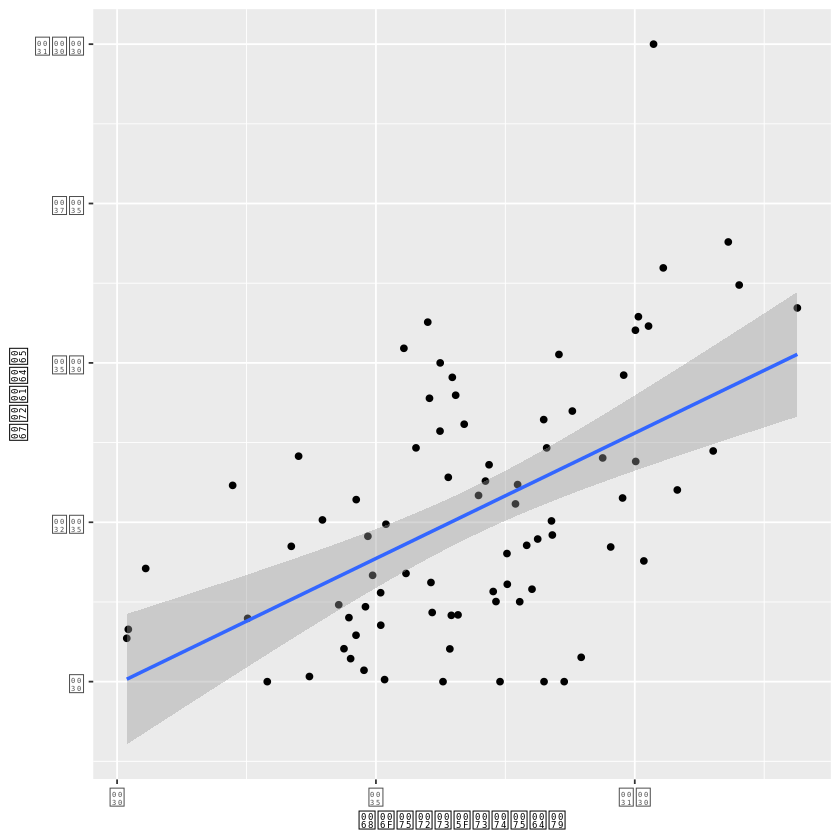

In [3]:
ggplot(CAT_DF, aes(x = hours_study, y = grade)) + geom_point() + geom_smooth(method = "lm")

In case you want *more* motivation to try a model that stratifies by breed, we can consider the residuals in for each of the breeds under a standard linear model. The residuals tend to be mainly positive or mainly negative within each breed, suggesting we might need to consider a model which accounts for breed.

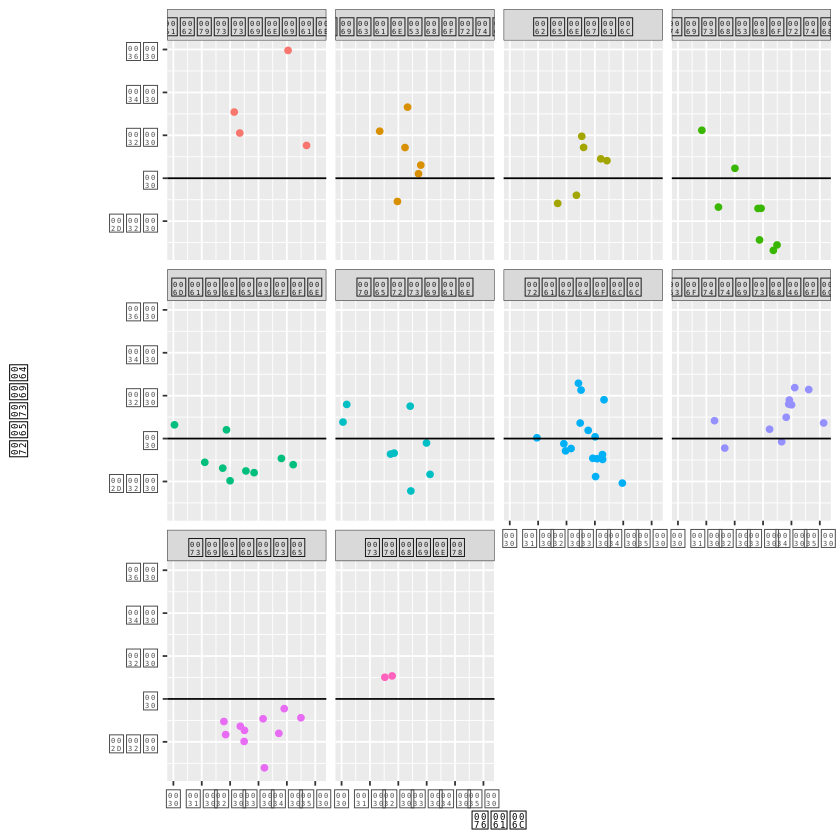

In [4]:
boring_lm <- lm(grade ~ hours_study, CAT_DF)
boring_df <- CAT_DF
boring_df$resid <- boring_lm$residuals
boring_df$val <- boring_lm$fitted.values

ggplot(boring_df, aes(y = resid, x = val, colour = breed)) + geom_point() + geom_hline(yintercept = 0) + facet_wrap(~breed) + theme(legend.position = "none")

To try and understand a bit more of the structure in this data, we could try fitting a linear model to each breed individually like in the following plot. However, that just shows that there isn't enough information to make any claims of significance. 

`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


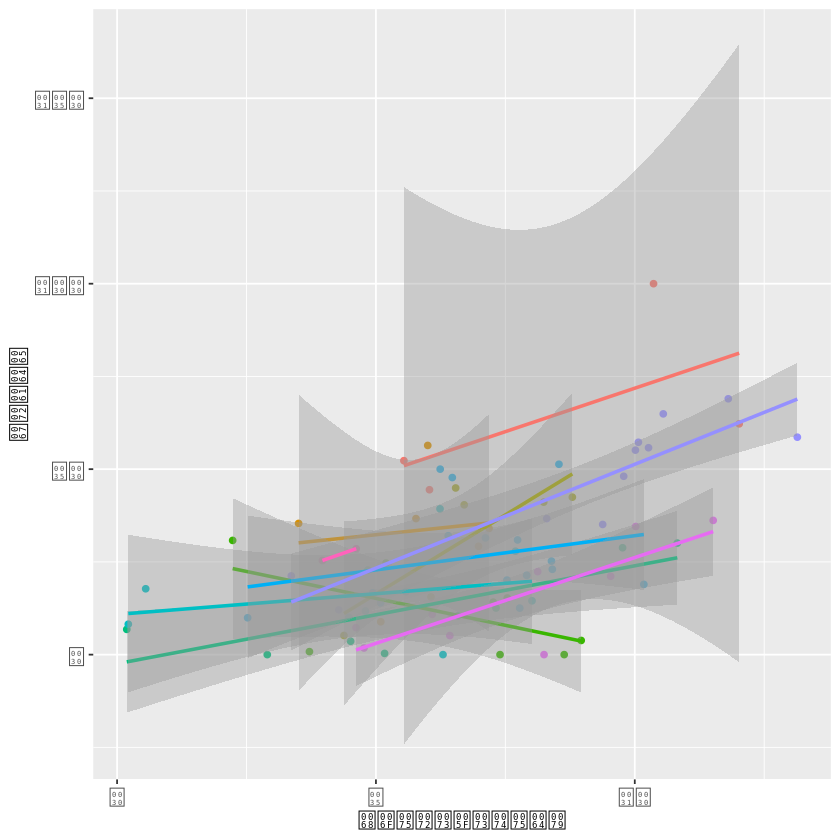

In [5]:
g1_with_col <- ggplot(data = CAT_DF, mapping = aes(x = hours_study, y = grade, colour = breed)) + geom_point() + theme(legend.position = "none")
g2_with_se <- g1_with_col + geom_smooth(method = "lm", se = TRUE) + theme(legend.position = "none")
print(g2_with_se)

To avoid the overplotting in the previous figure we can facet by the breed. This doesn't tell us anything new, but makes it easier to inspect the fits. Look! Scottishfolds appear to have a negative trend, that's strange.

`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


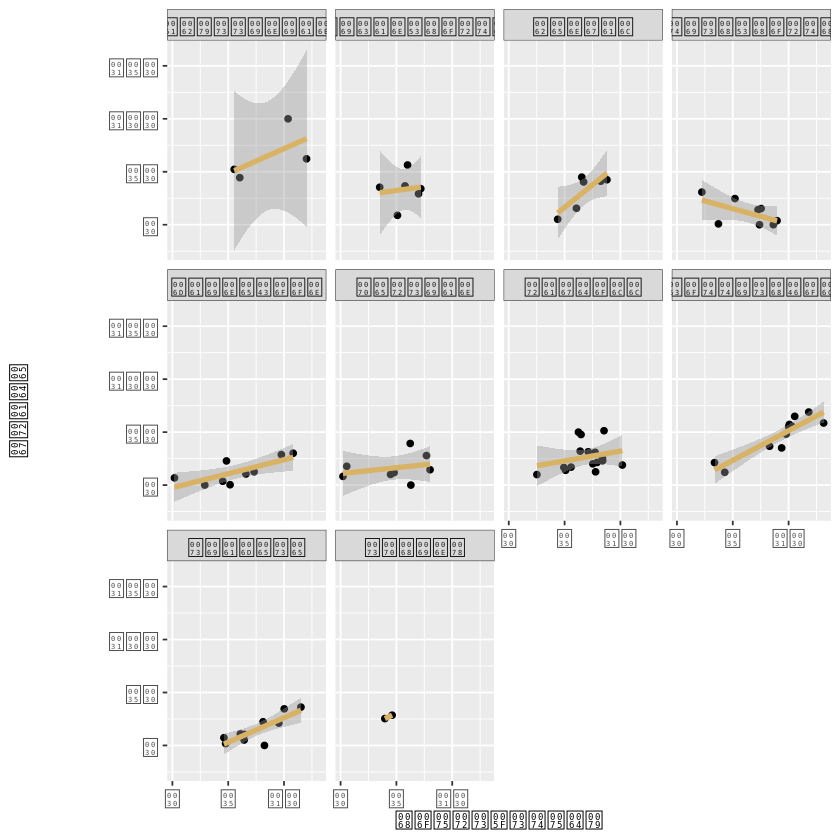

In [6]:
g1_without_col <- ggplot(data = CAT_DF, mapping = aes(x = hours_study, y = grade, group = breed)) + geom_point()
g2 <- g1_without_col + geom_smooth(method = "lm", se=TRUE, size = LINE_SIZE, colour = HEX_CODES[1]) + facet_wrap(~ breed)
g2

In [7]:
## Massive problem!
lm(grade ~ hours_study, filter(CAT_DF, breed == "britishShorthair")) %>% summary


Call:
lm(formula = grade ~ hours_study, data = filter(CAT_DF, breed == 
    "britishShorthair"))

Residuals:
    Min      1Q  Median      3Q     Max 
-18.084  -5.503   2.862   7.508  10.095 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   29.678     11.129   2.667   0.0372 *
hours_study   -2.903      1.647  -1.762   0.1285  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.5 on 6 degrees of freedom
Multiple R-squared:  0.3411,	Adjusted R-squared:  0.2312 
F-statistic: 3.105 on 1 and 6 DF,  p-value: 0.1285


## LMM formulation

We will now consider a LMM for this data. We will start with a more natural formulation, and then translate it into a form that can be understood by `lme4`. If you want to use LMM in practice you will probably need to go through this process yourself!

$$
k_{ij} = \alpha_{0i} + \alpha_{1i} t_{ij} + \epsilon_{ij}
$$

where $k_{ij}$ is the exam grade for breed $i$ at measurement number $j$, the variable $t_{ij}$ is the number of hours the cat spend studying for a member of breed $i$ at measurement number $j$ and $\epsilon_{ij}$ is random error.

We can consider the peculiarities of each cat by expressing these coefficients themselves as random variables: $\alpha_{li} = \gamma_{l} + \omega_{li}$. Then, we can re-express this model in terms of fixed and random effects as follows:

$$
k_{ij} = \gamma_{0} + \gamma_{1} t_{ij} + \omega_{0i} + \omega_{1i} t_{ij} + \epsilon_{ij}
$$

We are now in a good position to fit this model with `lme4`. Note that to indicate the random effects are indexed by `breed` there is the additional syntax `(var | factor)`.

**DEEP BREATH**

We are going to jump straight to a model with both a random intercept and a random slope. We do this for a couple of reasons: a) we include the random intercept because we know that there is variability acorss the breeds overall, both based on a priori understanding of the process and empirically from our exploratory data analysis, b) we are going to include a random slope, because as discussed by Barr et al (2013), this tends lead to fewer spurious results. Moreover, as we can see with the Scottish fold grades, there is clearly variation in the effectiveness of study which differs by breed.

https://www.sciencedirect.com/science/article/pii/S0749596X12001180#f0005



In [8]:
mlm_fit <- lmer(grade ~ hours_study + (hours_study | breed),
                        data = CAT_DF,
                REML = FALSE
)

We can then get the fitted values and plot these along with the linear model fits from before. *Hooray!* We are not getting much more sensible results out.

`geom_smooth()` using formula 'y ~ x'

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


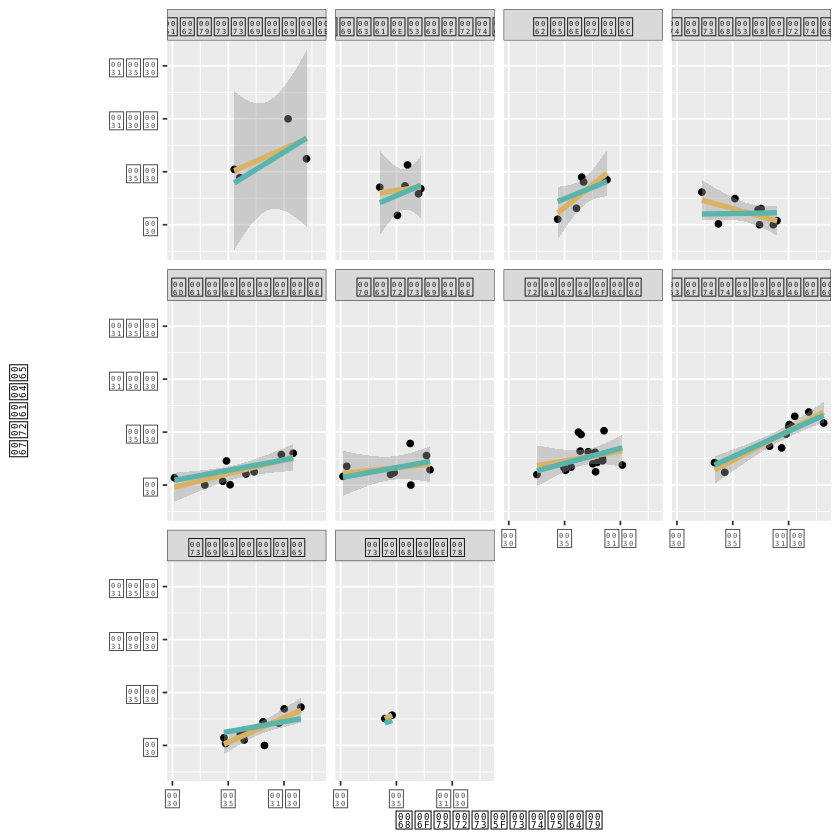

In [9]:
cat_df_with_lme_fit <- CAT_DF
cat_df_with_lme_fit$fit <- fitted(mlm_fit)

g3 <- g2 + geom_line(
             data = cat_df_with_lme_fit,
             mapping = aes(y = fit),
             size = LINE_SIZE,
             colour = HEX_CODES[2]
           )

g3

## Question

Wow, wow, wow! Slow down there, why do the fitted values look different for each time series?

## Partial answer

This question refers to the fact that if we only considered the estimates based on the fixed effects, the fitted values would look the same for all the cats. The fitted values differ because estimates of the random effects are used. The details of how this is done go beyond the scope of this course, but you can take comfort in the fact that these fitted values are the *best linear unbiased predictors* (BLUPs). If you want more details on this you can see Section 23.8 of Fox (2015).

## How do you explain this?

The following shows how you can use an ANOVA to generate a *p*-value that you can use to justify the significance of studying on exam marks

In [10]:
mlm_null_fit <- lmer(grade ~ 1 + (hours_study | breed),
                     data = CAT_DF,
                     REML = FALSE
                     )

anova(mlm_null_fit, mlm_fit)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mlm_null_fit,5,665.4451,677.3552,-327.7225,655.4451,NA,NA,NA
mlm_fit,6,659.6387,673.9309,-323.8194,647.6387,7.806382,1,0.005206203


In [11]:
summary(mlm_fit)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: grade ~ hours_study + (hours_study | breed)
   Data: CAT_DF

     AIC      BIC   logLik deviance df.resid 
   659.6    673.9   -323.8    647.6       74 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.61977 -0.62110 -0.08865  0.50638  2.40883 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 breed    (Intercept)  24.305   4.930        
          hours_study   4.119   2.029   -0.57
 Residual             145.530  12.064        
Number of obs: 80, groups:  breed, 10

Fixed effects:
            Estimate Std. Error t value
(Intercept)   5.0119     4.4674   1.122
hours_study   3.2880     0.9009   3.650

Correlation of Fixed Effects:
            (Intr)
hours_study -0.749

## Diagnostics and model fit

We can plot the residuals against the fitted values to look for systematic errors in the model fit. 

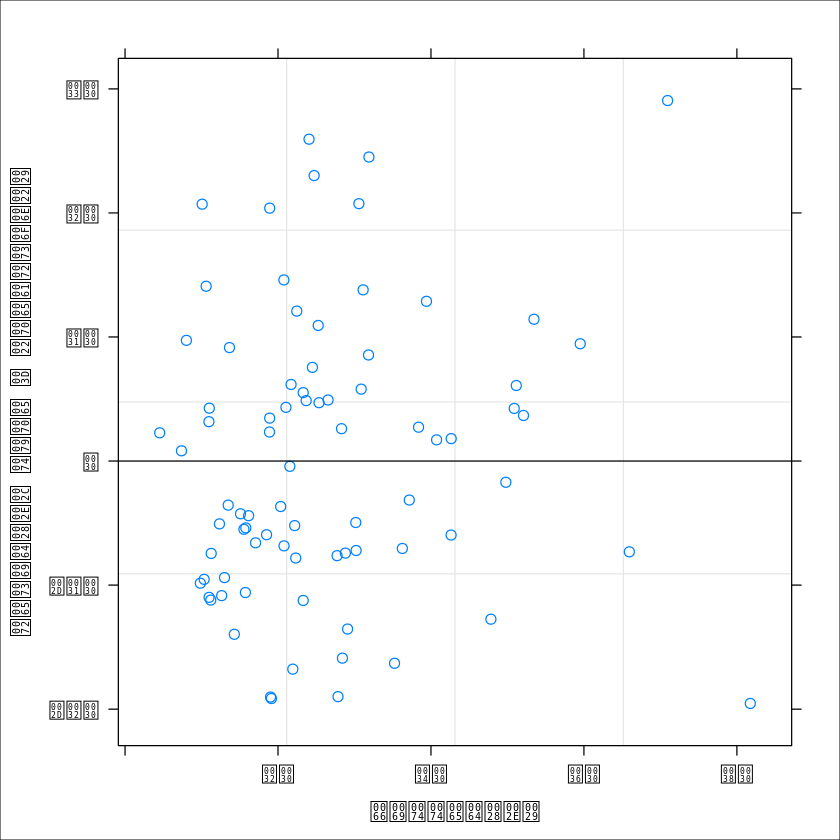

In [12]:
plot(mlm_fit)

Although the standard deviations and the estimates of the fixed effects are given in the summary of the model fit, there can be correlations which mean that we might want to use a more sophisticated method to estimate the CI. Here we will just use the Wald method to generate the CI which does not correct for this sort of error, but if you look up the documentation of `confint.merMod` it will list the available methods.


In [13]:
confint.merMod(mlm_fit, "hours_study", method = "profile")

Computing profile confidence intervals ...



,2.5 %,97.5 %
hours_study,1.256101,5.405982


The `MuMIn` package provides a helper function to compute an analogue of $R^2$ for generalised LMMs. There are two values returned, the first is the *marginal* $R^2$, which is the variability explained by the fixed effects alone, and then there is the *conditional* $R^2$ which reports the variability explained by both fixed and random effects. The stark difference between the $R^2$ values suggests that a large amount of  the variability is due to the random effects. This may not have been easy to see looking at the coefficients reported by the summary alone!


In [14]:
r.squaredGLMM(mlm_fit)

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


R2m,R2c
0.1988141,0.627427
